In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from keras import layers

2023-02-17 10:19:49.648014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 10:19:49.908752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marc/Studium/WS22-23/Database Systems/dbsys22/build/debug/mutable/src/Mutable/lib:/usr/local/boost_1_80_0/stage/lib
2023-02-17 10:19:49.908865: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-17 10:19:50.801449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

In [2]:
data_file = '../../../data/HertzianContact/dataWithLabelled.csv'

column_names = ['radius Curvature', 'surface Energy', 'pulloff Force']

data = pd.read_csv(data_file)
data.head()

,radius Curvature,surface Energy,pulloff Force
0,8.826360e-07,0.013163,5.474700e-08
1,7.556060e-02,0.045870,1.633310e-02
2,5.327680e-02,0.021904,5.499170e-03
3,4.704560e-03,0.067890,1.505090e-03
4,6.792970e-02,0.093470,2.992080e-02


In [3]:
dataset = data.copy()

# scaling pulloff Force
#dataset  = dataset.apply(lambda x: 1_000_000*x if x.name == 'pulloff Force' else x)

dataset.tail()

,radius Curvature,surface Energy,pulloff Force
995,0.003038,0.058216,0.000833
996,0.064165,0.015514,0.004691
997,0.006826,0.030759,0.000989
998,0.057431,0.036867,0.009978
999,0.021003,0.003507,0.000347


In [4]:
train_dataset = dataset.sample(frac=0.85, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

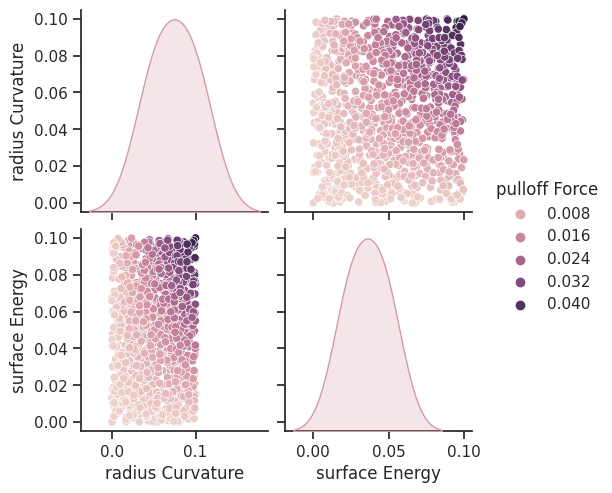

In [5]:
sns.set_theme(style="ticks")
sns.pairplot(data, hue='pulloff Force')

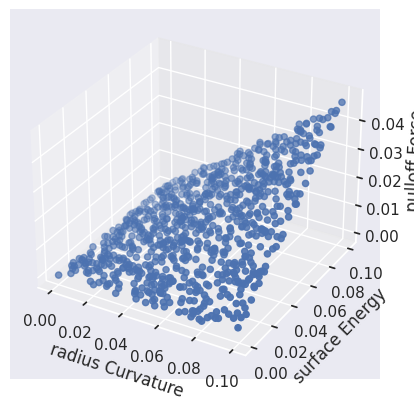

In [6]:
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = train_dataset['radius Curvature']
y = train_dataset['surface Energy']
z = train_dataset['pulloff Force']

ax.set_xlabel("radius Curvature")
ax.set_ylabel("surface Energy")
ax.set_zlabel("pulloff Force")

ax.scatter(x, y, z)

plt.show()

In [7]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('pulloff Force')
test_labels = test_features.pop('pulloff Force')

In [8]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
radius Curvature,0.051010,0.028462
surface Energy,0.049118,0.028054
pulloff Force,0.011802,0.010218


In [9]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2023-01-17 16:52:43.398525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marc/Studium/WS22-23/Database Systems/dbsys22/build/debug/mutable/src/Mutable/lib:/usr/local/boost_1_80_0/stage/lib
2023-01-17 16:52:43.398628: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-17 16:52:43.398655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Marc-HP): /proc/driver/nvidia/version does not exist
2023-01-17 16:52:43.399062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other oper

[[0.05101043 0.04911796]]


In [10]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(256, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(256, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1)
  ])

  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(5e-3))
  return model

In [11]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              5

In [12]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    batch_size=200,
    validation_split=0.2,
    epochs=2000)

Epoch 1/2000


/home/marc/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


4/4 [==============================] - 2s 76ms/step - loss: 1.4253 - val_loss: 0.1173
Epoch 2/2000
4/4 [==============================] - 0s 20ms/step - loss: 1.2033 - val_loss: 0.0767
Epoch 3/2000
4/4 [==============================] - 0s 20ms/step - loss: 1.1406 - val_loss: 0.0473
Epoch 4/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.9994 - val_loss: 0.0756
Epoch 5/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.7876 - val_loss: 0.0338
Epoch 6/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.6122 - val_loss: 0.0553
Epoch 7/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.4777 - val_loss: 0.0281
Epoch 8/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.3779 - val_loss: 0.0151
Epoch 9/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.2825 - val_loss: 0.0338
Epoch 10/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.2282 - val_loss: 0.0477
Epoch 11/2000
4/4 [===

In [13]:
def plot_loss(history):
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [pulloff Force]')
  plt.legend()
  plt.grid(True)

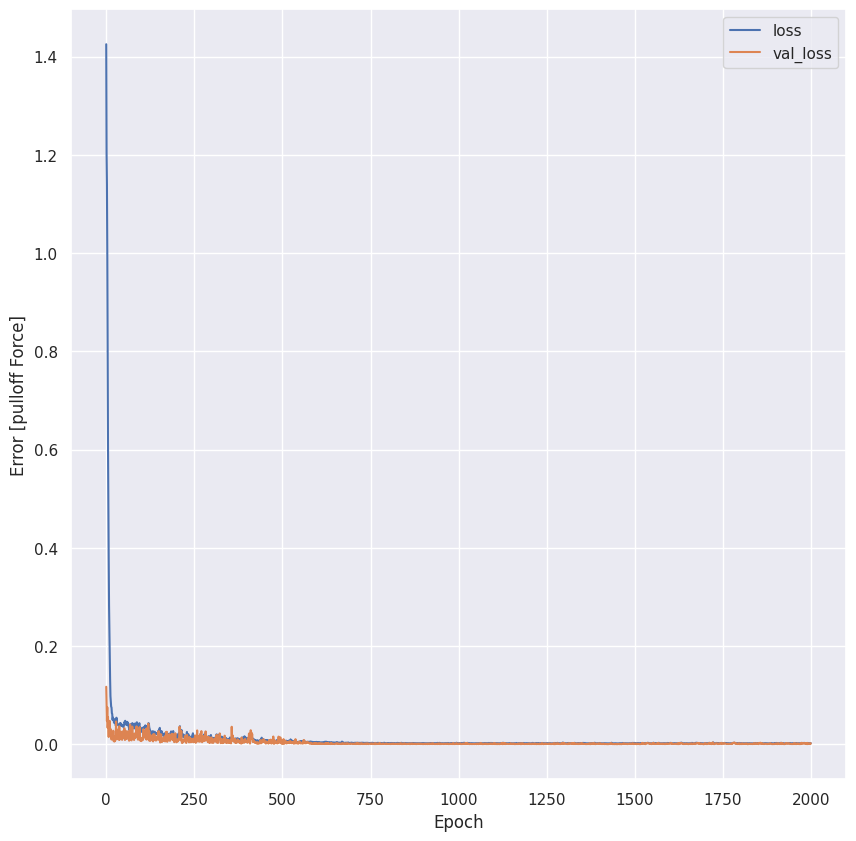

In [14]:
plot_loss(history)

In [15]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels)

5/5 [==============================] - 0s 3ms/step - loss: 0.0022


In [16]:
pd.DataFrame(test_results, index=['Mean absolute error [pulloff Force]']).T

,Mean absolute error [pulloff Force]
dnn_model,0.002188


5/5 [==============================] - 0s 3ms/step


Text(0, 0.5, 'Predictions [pulloff Force]')

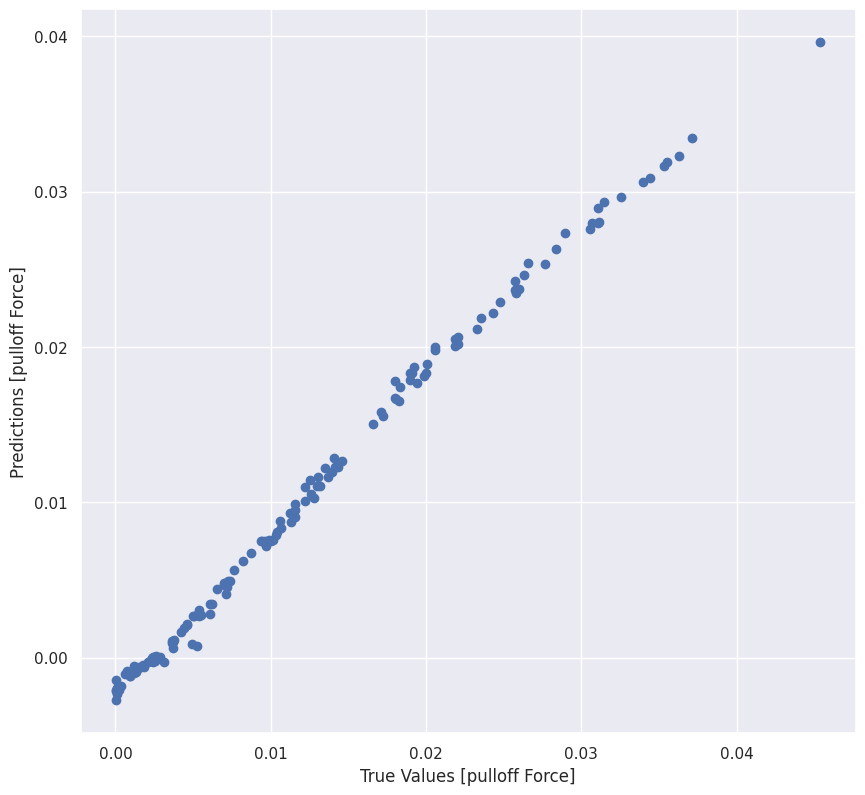

In [18]:
test_predictions = dnn_model.predict(test_features).flatten()

plt.figure(figsize=(10,10))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pulloff Force]')
plt.ylabel('Predictions [pulloff Force]')

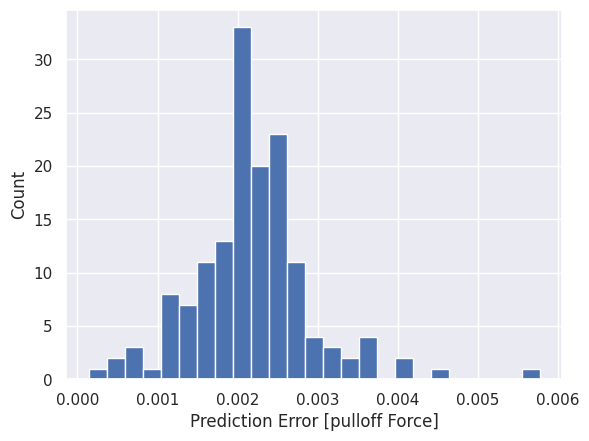

In [22]:
error = abs(test_predictions - test_labels)
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [pulloff Force]')
_ = plt.ylabel('Count')

In [23]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


INFO:tensorflow:Assets written to: dnn_model/assets
